#  1. Импортируем библиотеки и загрузим данные

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import collections
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import plotly.express as px

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

#import requests
#from bs4 import BeautifulSoup as bs


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/russ174/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [2]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [5]:
# Подгрузим наши данные из соревнования

DATA_DIR = 'https://github.com/RuslanMavlitov/sf_data_science/raw/main/Project_3_EDA/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv.zip') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv.zip') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv.zip') # самбмишн

In [1]:
print(df_train.duplicated())
df_train.drop_duplicates()

NameError: name 'df_train' is not defined

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


## Расшифровка признаков
hotel_address — адрес отеля;

review_date — дата, когда рецензент разместил соответствующий отзыв;

average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;

hotel_name — название отеля;

reviewer_nationality — страна рецензента;

negative_review — отрицательный отзыв, который рецензент дал отелю;

review_total_negative_word_counts — общее количество слов в отрицательном отзыв;

positive_review — положительный отзыв, который рецензент дал отелю;

review_total_positive_word_counts — общее количество слов в положительном отзыве.

reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;

total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;

total_number_of_reviews — общее количество действительных отзывов об отеле;

tags — теги, которые рецензент дал отелю;

days_since_review — количество дней между датой проверки и датой очистки;

additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.

lat — географическая широта отеля;

lng — географическая долгота отеля.

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [58]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
hotels

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,nights
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,NaN
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,NaN
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,NaN
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0,NaN
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,"[' Leisure trip ', ' Group ', ' Club Double or...",106 day,51.494028,-0.191050,1,8.8,2.0
515734,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,1,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171 day,48.192379,16.399451,1,9.2,4.0
515735,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,51.520795,-0.131084,1,8.3,1.0
515736,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.515125,-0.160066,1,9.2,2.0


# 2. EDA

### 2.1 Признак 'review_date' 

In [59]:
# Добавляем признак дня недели и месяца комментария, удаляем признак даты комментария
hotels['review_date'] = pd.to_datetime(hotels['review_date'], format='%m/%d/%Y')
hotels['month'] = hotels['review_date'].dt.month.astype(int)
hotels['dayofweek'] = hotels['review_date'].dt.dayofweek.astype(int)
hotels = hotels.drop(['review_date'], axis=1)

### 2.2 Признаки 'positive_review' и 'negative_review'

In [60]:
def clean(text):
    ''' Проведем небольшую чистку текста от типовых сокращений и обозначений'''
    text = text.lower()
    text = text.replace("ain't", "am not")
    text = text.replace("aren't", "are not")
    text = text.replace("can't", "cannot")
    text = text.replace("can't've", "cannot have")
    text = text.replace("'cause", "because")
    text = text.replace("could've", "could have")
    text = text.replace("couldn't", "could not")
    text = text.replace("couldn't've", "could not have")
    text = text.replace("should've", "should have")
    text = text.replace("should't", "should not")
    text = text.replace("should't've", "should not have")
    text = text.replace("would've", "would have")
    text = text.replace("would't", "would not")
    text = text.replace("would't've", "would not have")
    text = text.replace("didn't", "did not")
    text = text.replace("doesn't", "does not")
    text = text.replace("don't", "do not")
    text = text.replace("hadn't", "had not")
    text = text.replace("hadn't've", "had not have")
    text = text.replace("hasn't", "has not")
    text = text.replace("haven't", "have not")
    text = text.replace("haven't", "have not")
    text = text.replace("haven't", "have not")
    text = text.replace("haven't", "have not")
    text = text.replace("he'd", "he would")
    text = text.replace("haven't", "have not")
    text = text.replace("he'd've", "he would have")
    text = text.replace("'s", "")
    text = text.replace("'t", "")
    text = text.replace("'ve", "")
    text = text.replace(".", " . ")
    text = text.replace("!", " ! ")
    text = text.replace("?", " ? ")
    text = text.replace(";", " ; ")
    text = text.replace(":", " : ")
    text = text.replace(",", " , ")
    text = text.replace("´", "")
    text = text.replace("‘", "")
    text = text.replace("’", "")
    text = text.replace("“", "")
    text = text.replace("”", "")
    text = text.replace("\'", "")
    text = text.replace("\"", "")
    text = text.replace("-", "")
    text = text.replace("–", "")
    text = text.replace("—", "")
    text = text.replace("[", "")
    text = text.replace("]","")
    text = text.replace("{","")
    text = text.replace("}", "")
    text = text.replace("/", "")
    text = text.replace("|", "")
    text = text.replace("(", "")
    text = text.replace(")", "")
    text = text.replace("$", "")
    text = text.replace("+", "")
    text = text.replace("*", "")
    text = text.replace("%", "")
    text = text.replace("#", "")
    text = text.replace("\n", " \n ")
    text = text.replace("\n", "")
    text = text.replace("_", " _ ")
    text = text.replace("_", "")
    text = ''.join([i for i in text if not i.isdigit()])

    return text

hotels['positive_review'] = hotels['positive_review'].apply(clean)
hotels['negative_review'] = hotels['negative_review'].apply(clean)

In [62]:
# Определяем содержит ли отзыв негативные содержание 
# Определяем содержит ли отзыв положительное содержание 
def negative(answer):
    if 'nothing' in answer.lower() or 'none' in answer.lower() or 'n a' in answer.lower() or 'no negative' in answer.lower():
        return 0
    else:
        return 1
    
def positive(answer):
    if 'nothing' in answer.lower() or 'none' in answer.lower() or 'n a' in answer.lower() or 'no positive' in answer.lower():
        return 0
    else:
        return 1
    
hotels['is_positive_review'] = hotels['positive_review'].apply(positive) 
hotels['is_negative_review'] = hotels['negative_review'].apply(negative)

In [63]:
hotels['neg_words'] = hotels['negative_review'].apply(
    lambda x: 1 if ("expensive" in x.lower().split()
                    or "small" in x.lower().split()
                    or "service" in x.lower().split()
                   or "dirty" in x.lower().split()
                   or "location" in x.lower().split()
                   or "staff" in x.lower().split()
                   or "bad" in x.lower().split()) else 0)
hotels['neg_words'].value_counts() 

0    397888
1    117850
Name: neg_words, dtype: int64

In [64]:
hotels['pos_words'] = hotels['positive_review'].apply(
    lambda x: 1 if ("excellent" in x.lower().split()
                    or "great" in x.lower().split()
                    or "service" in x.lower().split()
                   or "clean" in x.lower().split()
                   or "location" in x.lower().split()
                   or "staff" in x.lower().split()) else 0)
hotels['pos_words'].value_counts() 

1    354616
0    161122
Name: pos_words, dtype: int64

In [65]:
hotels['booking_n'] = hotels['negative_review'].apply(lambda x: 1 if ("booking" in x.lower().split()) or ("booking.com" in x.lower().split()) else 0)
hotels['booking_n'].value_counts()

0    506691
1      9047
Name: booking_n, dtype: int64

In [66]:
# Анализируем отзывы 
# Данная библиотека даст нам оценку комментария и уровень влияния (положительный, отрицательный и нейтральный)
sent_analyzer = SentimentIntensityAnalyzer()

hotels['rw_neg'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
hotels['rw_pos'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)) 
    
hotels.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(hotels['rw_neg'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
hotels.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(hotels['rw_pos'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)

In [67]:
# Уберем текст с более 25 словами к одному значению
hotels['review_total_negative_word_counts'] = hotels['review_total_negative_word_counts'].apply(lambda x: 25 if x > 25 else x)
hotels['review_total_positive_word_counts'] = hotels['review_total_positive_word_counts'].apply(lambda x: 25 if x > 25 else x)

In [68]:
# Выведем процентное содержание позитивных и негативных слов
hotels['positive_word_per'] = 100 * hotels['review_total_positive_word_counts'] / (hotels['review_total_negative_word_counts'] + hotels['review_total_positive_word_counts'])
hotels['negative_word_per'] = 100 * hotels['review_total_negative_word_counts'] / (hotels['review_total_negative_word_counts'] + hotels['review_total_positive_word_counts'])
hotels['#_pos_words'] = hotels['review_total_positive_word_counts'] / hotels['total_number_of_reviews_reviewer_has_given']
hotels['#_neg_words'] = hotels['review_total_negative_word_counts'] / hotels['total_number_of_reviews_reviewer_has_given']
hotels['pos_rev_rate'] = hotels['review_total_positive_word_counts'] / hotels['total_number_of_reviews']
hotels['neg_rev_rate'] = hotels['review_total_negative_word_counts'] / hotels['total_number_of_reviews']
hotels['positive_word_per'].fillna(0,inplace=True)
hotels['negative_word_per'].fillna(0,inplace=True)
hotels['add_pos_rate'] = hotels['review_total_positive_word_counts'] / hotels['additional_number_of_scoring']
hotels['add_neg_rate'] = hotels['review_total_negative_word_counts'] / hotels['total_number_of_reviews']
    
hotels['review_rate'] = hotels['total_number_of_reviews_reviewer_has_given'] / hotels['total_number_of_reviews']

### 2.3 Разберем признаки адреса, долготы и широты ('hotel_address', 'lat' и 'lng')

In [69]:
# Разберемся с признаками №15-16 долготы и широты наших отелей.
# Не будем их удалять сразу, а попробуем достать с помощью визуализации из них информацию.

coordinates = hotels.loc[:, ('hotel_name', 'lat', 'lng')]
print(f'Всего координат в базе данных: {coordinates.shape}')   

# данные не сгруппированы по отелям 384355 строк слишком много
# оставим только по одной координате на отель

coordinates = coordinates.drop_duplicates()  
print(f'Всего уникальных координат в базе данных: {coordinates.shape}')

# Уберем пустые значения
print(f'Всего пустых координат в базе данных: {coordinates.isnull().values.sum()}')
coordinates = coordinates[coordinates['lat'].notna()]
print(f'После удаления пустых координат в базе данных: {coordinates.isnull().values.sum()}')

# В итоге получеам
print(f'Итого в базе данных: {coordinates.shape[0]} координат')

Всего координат в базе данных: (515738, 3)
Всего уникальных координат в базе данных: (1494, 3)
Всего пустых координат в базе данных: 34
После удаления пустых координат в базе данных: 0
Итого в базе данных: 1477 координат


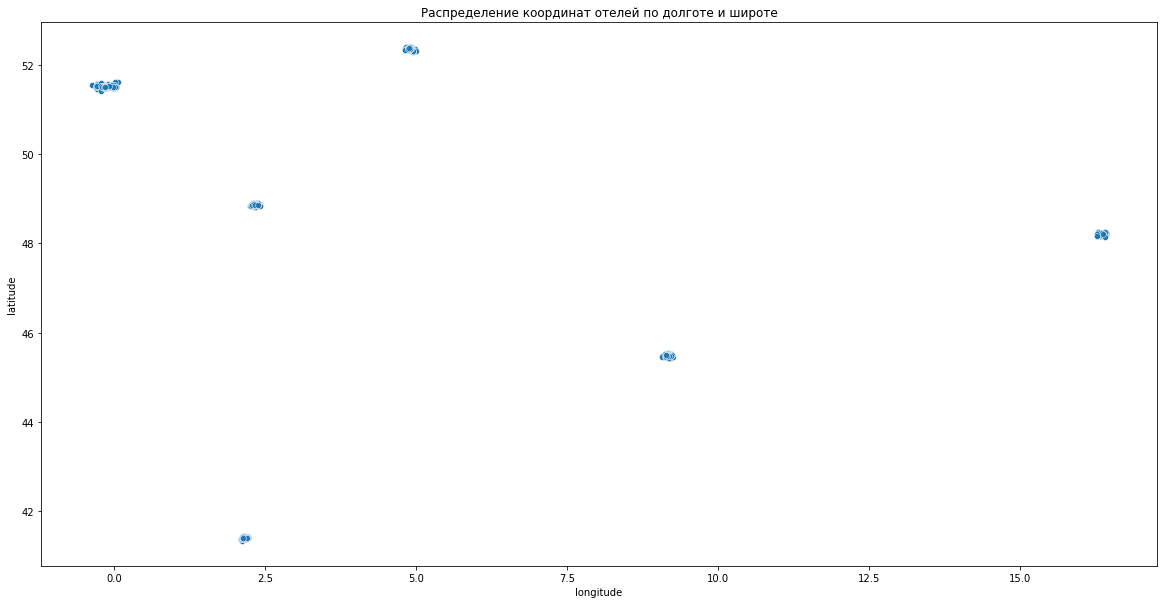

In [70]:
# Накидаем их все в один график
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

sns.scatterplot(
    x=coordinates['lng'],
    y=coordinates['lat'],
    ax=ax)
ax.set_title('Распределение координат отелей по долготе и широте')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.show()

# Все координаты собрались в 6 разных точках, то есть городах. 

       По координатам выяснили, что в базе данных у нас отели всего 6 городов. Так как отдельного признака "Город" нет, выясним какие это города и создадим из них признак "город"

In [71]:
# Наложим наши точки на карту и вуаля!!!
px.set_mapbox_access_token(
    'pk.eyJ1IjoicnVzczE3NCIsImEiOiJjbDE2ZWlnaGUwMTduM2NwOXY4aTE4bmtvIn0.JoLjc9UsW6b_XBukzS03zQ'
)

fig = px.scatter_mapbox(
    coordinates,
    lat="lat", lon="lng",
    hover_name="hotel_name",
    size_max=15, zoom=3.5,
)
fig.update_layout(
    title={'text': "Все отели на карте", 'x':0.5}
)
fig.show()

    Города:
        1. Лондон
        2. Париж
        3. Амстердам
        4. Барселона
        5. Милан
        6. Вена

In [72]:
# Оставим в признаке адрес только город и сразу его в категориальный признак приведём.

def get_hotel_city(text):
    if 'london' in text.lower().split():
        return 1
    if 'paris' in text.lower().split():
        return 2
    if 'amsterdam' in text.lower().split():
        return 3
    if 'milan' in text.lower().split():
        return 5
    if 'barcelona' in text.lower().split():
        return 4
    if 'vienna' in text.lower().split():
        return 6
    else:
        return text

hotels['city'] = hotels['hotel_address'].apply(get_hotel_city)
print(f'Проверим что ничего не потеряли: {hotels["city"].shape[0] == hotels["hotel_name"].shape[0]}')
print(f'Проверим что в списке только наши города от 1 до 6: {hotels["city"].unique()}')

Проверим что ничего не потеряли: True
Проверим что в списке только наши города от 1 до 6: [5 3 4 1 2 6]


### 2.4 Признак 'days_since_review' (давности комментария в днях) 

In [73]:
#В признаке "количество дней с момента отзыва" оставим только число дней.
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(''.join(x.split()[0])))

### 2.5 Признак 'average_score' (средней оценки)

<AxesSubplot:>

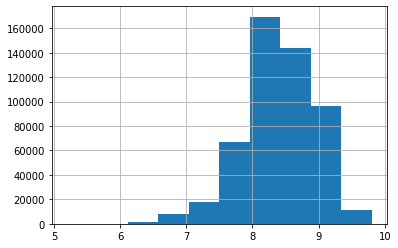

In [74]:
hotels['average_score'].hist()

In [75]:
#Создаём категории средних оценок
def score_group(score):
    if score >= 9.2:
        return 'excelent'
    elif 8.5 < score < 9.2:
        return 'high'
    elif score < 8.5 and score >= 7.8:
        return 'good'
    else:
        return 'normal'
    
hotels['hotel_level'] = hotels['average_score'].apply(score_group) 

### 2.6 Признак 'reviewer_nationality' (национальности комментатора)

In [76]:
# Оставим топ 20 стран рецензентов
top_reviewer_nationality = list(hotels['reviewer_nationality'].value_counts()[:20].index)
print(top_reviewer_nationality)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x if x in top_reviewer_nationality else 'other')
hotels['reviewer_nationality'].value_counts()

[' United Kingdom ', ' United States of America ', ' Australia ', ' Ireland ', ' United Arab Emirates ', ' Saudi Arabia ', ' Netherlands ', ' Switzerland ', ' Germany ', ' Canada ', ' France ', ' Israel ', ' Italy ', ' Belgium ', ' Turkey ', ' Kuwait ', ' Spain ', ' Romania ', ' Russia ', ' South Africa ']


 United Kingdom               245246
other                          92646
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
 France                         7296
 Israel                         6610
 Italy                          6114
 Belgium                        6031
 Turkey                         5444
 Kuwait                         4920
 Spain                          4737
 Romania                        4552
 Russia                         3900
 South Africa                   3821
Name: reviewer_nationality, dtype: int64

### 2.7 Признак 'tags' 

In [77]:
# Определяем тип путешествия по признаку tags
def trip(tag):
    tag_list = tag.split(', ')
    trip_kind = tag_list[0]
    trip_kind = re.findall(r'\w+\s\w+', trip_kind)
    result = ''.join(trip_kind)
    if result == 'Leisure trip':
        return 1
    elif result == 'Business trip':
        return 2
    else:
        return 0

hotels['kind_of_trip'] = hotels['tags'].apply(trip)
hotels['kind_of_trip'].value_counts()

1    416672
2     82748
0     16318
Name: kind_of_trip, dtype: int64

### 2.8 Добавляем новый признак 'location' (расстояние до центра города)

In [78]:
# Заполним пропуски в данных модой
fill_group_data = hotels.copy()

fill_group_data['lat'] = fill_group_data['lat'].fillna(fill_group_data.groupby('city')['lat'].transform('median'))
fill_group_data['lng'] = fill_group_data['lng'].fillna(fill_group_data.groupby('city')['lng'].transform('median'))
fill_group_data.isnull().sum() == 0

hotel_address                                  True
additional_number_of_scoring                   True
average_score                                  True
hotel_name                                     True
reviewer_nationality                           True
negative_review                                True
review_total_negative_word_counts              True
total_number_of_reviews                        True
positive_review                                True
review_total_positive_word_counts              True
total_number_of_reviews_reviewer_has_given     True
tags                                           True
days_since_review                              True
lat                                            True
lng                                            True
sample                                         True
reviewer_score                                 True
nights                                        False
month                                          True
dayofweek   

In [82]:
# Добавим новый признак расстояние до центра
def location_dist(x):
    lon = x[0]
    lat = x[1]
    city = x[2]
    lat_1 = 51.507
    lon_1 = -0.127
    lat_2 = 48.862
    lon_2 = 2.336
    lat_3 = 52.374
    lon_3 = 4.897
    lat_4 = 41.383
    lon_4 = 2.178
    lat_5 = 45.467
    lon_5 = 9.190
    lat_6 = 48.208
    lon_6 = 16.373   
    if city == 1:
        dist = ((lon - lon_1)**2 + (lat - lat_1)**2)**0.5
        return dist
    if city == 2:
        dist = ((lon - lon_2)**2 + (lat - lat_2)**2)**0.5
        return dist
    if city == 3:
        dist = ((lon - lon_3)**2 + (lat - lat_3)**2)**0.5
        return dist
    if city == 4:
        dist = ((lon - lon_4)**2 + (lat - lat_4)**2)**0.5
        return dist
    if city == 5:
        dist = ((lon - lon_5)**2 + (lat - lat_5)**2)**0.5
        return dist
    if city == 6:
        dist = ((lon - lon_6)**2 + (lat - lat_6)**2)**0.5
        return dist
    else:
        return np.nan

    
#hotels['location'] = hotels[['lng', 'lat', 'city']].apply(location_dist, axis = 1)
hotels['location'] = fill_group_data[['lng', 'lat', 'city']].apply(location_dist, axis = 1)

In [83]:
print(hotels['location'].isna().sum())
hotels['location'].describe()

0


count    515738.000000
mean          0.039258
std           0.035605
min           0.000183
25%           0.013669
50%           0.027886
75%           0.053779
max           0.245044
Name: location, dtype: float64

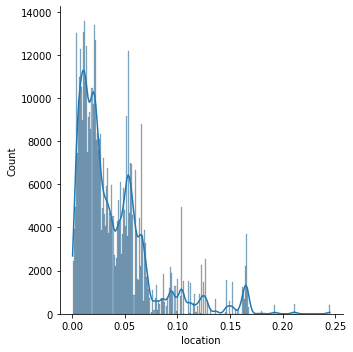

In [84]:
sns.displot(x='location',
            kde=True,
            data=hotels)

<AxesSubplot:xlabel='location', ylabel='reviewer_score'>

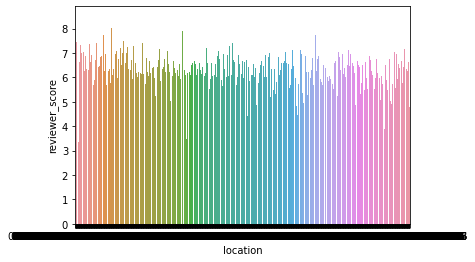

In [91]:
sns.barplot(
    x='location',y='reviewer_score',
    data=hotels.groupby('location')['reviewer_score'].mean().reset_index().sort_values(by='location',ascending=False))

### 2.9 Кодируем строковые признаки

In [92]:
# Кодируем объекты типа Object
import category_encoders as ce

encoder = ce.OneHotEncoder(cols = ['kind_of_trip', 'hotel_level'])
type_bin = encoder.fit_transform(hotels.loc[:, ['kind_of_trip', 'hotel_level']])

df = hotels.copy()
df = pd.concat([df, type_bin], axis=1)

bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality', 'hotel_name', 'city'])
type_bin = bin_encoder.fit_transform(hotels.loc[:, ['reviewer_nationality', 'hotel_name', 'city']])
df = pd.concat([df, type_bin], axis=1)

df.drop(['kind_of_trip', 'hotel_level', 'reviewer_nationality', 'hotel_name', 'city'], axis=1, inplace=True)

### 2.10 Стандартизаруем признаки к единой шкале

In [93]:
from sklearn import preprocessing
#инициализируем нормализатор MinMaxScaler
col_names = ['#_pos_words', '#_neg_words', 'pos_rev_rate', 'neg_rev_rate',
             'add_pos_rate', 'add_neg_rate', 'review_rate', 'average_score',
             'location', 'additional_number_of_scoring','total_number_of_reviews',
             'days_since_review', 'dayofweek', 'month', 'review_total_negative_word_counts',
             'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given']
mm_scaler = preprocessing.MinMaxScaler()

# копируем исходный датасет
df_mm = mm_scaler.fit_transform(df.loc[:, ['#_pos_words', '#_neg_words',
                                           'pos_rev_rate', 'neg_rev_rate',
                                           'add_pos_rate', 'add_neg_rate', 'review_rate',
                                           'average_score', 'location', 'additional_number_of_scoring',
                                           'total_number_of_reviews', 'days_since_review', 'dayofweek',
                                           'month', 'review_total_negative_word_counts',
                                           'review_total_positive_word_counts',
                                           'total_number_of_reviews_reviewer_has_given']])

df_mm = pd.DataFrame(df_mm, columns=col_names)
df.drop(col_names, axis=1, inplace=True)
df = pd.concat([df, df_mm], axis=1)
df.head()

,hotel_address,negative_review,positive_review,tags,lat,lng,sample,reviewer_score,is_positive_review,is_negative_review,...,average_score,location,additional_number_of_scoring,total_number_of_reviews,days_since_review,dayofweek,month,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given
0,Via Senigallia 6 20161 Milan Italy,would have appreciated a shop in the hotel th...,hotel was great clean friendly staff free bre...,"[' Leisure trip ', ' Couple ', ' Double Room '...",45.533137,9.171102,0,0.0,1,1,...,0.630435,0.280164,0.336815,1.000000,0.017808,0.666667,0.545455,1.00,1.00,0.000000
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,no tissue paper box was present at the room,no positive,"[' Leisure trip ', ' Group ', ' Triple Room ',...",52.385649,4.834443,0,0.0,0,1,...,0.739130,0.259125,0.227900,0.299212,0.320548,0.000000,1.000000,0.40,0.00,0.016949
2,Mallorca 251 Eixample 08008 Barcelona Spain,pillows,nice welcoming and service,"[' Business trip ', ' Solo traveler ', ' Twin ...",41.393192,2.161520,0,0.0,1,1,...,0.673913,0.078387,0.016785,0.018524,0.843836,0.500000,0.909091,0.12,0.20,0.039548
3,Piazza Della Repubblica 17 Central Station 201...,no negative,everything including the nice upgrade the hot...,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",45.479888,9.196298,0,0.0,1,0,...,0.847826,0.057836,0.089519,0.090215,0.898630,0.833333,0.818182,0.00,1.00,0.022599
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,no negative,lovely hotel v welcoming staff,"[' Business trip ', ' Solo traveler ', ' Class...",52.370545,4.888644,0,0.0,1,0,...,0.847826,0.036182,0.310705,0.279305,0.608219,0.000000,0.363636,0.00,0.28,0.002825


### 2.11 Удаляем ненужные признаки типа "object"

In [94]:
list(df.select_dtypes(['object']).columns)

['hotel_address',
 'negative_review',
 'positive_review',
 'tags',
 'rw_neg',
 'rw_pos']

In [95]:
col_names = ['lat', 'lng', 'hotel_address', 'negative_review', 'positive_review', 'tags', 'rw_neg', 'rw_pos']
df.drop(col_names, axis=1, inplace=True)

### 2.12 Отбор признаков

In [96]:
df.columns

Index(['sample', 'reviewer_score', 'is_positive_review', 'is_negative_review',
       'neg_words', 'pos_words', 'booking_n', 'n_neg', 'n_neu', 'n_pos',
       'n_compound', 'p_neg', 'p_neu', 'p_pos', 'p_compound',
       'positive_word_per', 'negative_word_per', 'kind_of_trip_1',
       'kind_of_trip_2', 'kind_of_trip_3', 'hotel_level_1', 'hotel_level_2',
       'hotel_level_3', 'hotel_level_4', 'reviewer_nationality_0',
       'reviewer_nationality_1', 'reviewer_nationality_2',
       'reviewer_nationality_3', 'reviewer_nationality_4', 'hotel_name_0',
       'hotel_name_1', 'hotel_name_2', 'hotel_name_3', 'hotel_name_4',
       'hotel_name_5', 'hotel_name_6', 'hotel_name_7', 'hotel_name_8',
       'hotel_name_9', 'hotel_name_10', 'city_0', 'city_1', 'city_2',
       '#_pos_words', '#_neg_words', 'pos_rev_rate', 'neg_rev_rate',
       'add_pos_rate', 'add_neg_rate', 'review_rate', 'average_score',
       'location', 'additional_number_of_scoring', 'total_number_of_reviews',
       'day

Используем анализ мультиколлинеарности как шаг отбора признаков для модели.
    Признаки могут дублировать информацию. Анализ мультиколлинеарности мы будем использовать, чтобы выбрать уникальные признаки для модели.

Также перед обучением (после разделения выборки на X и y) мы можем оценить значимость каждого признака для целевой переменной — рейтинг отеля. 

In [97]:
# Для начала разделим признаки по типу, перечислим их:

# непрерывные признаки
num_cols = ['n_neg', 'n_neu', 'n_pos', 'n_compound', 'p_neg',
       'p_neu', 'p_pos', 'p_compound', 'positive_word_per',
       'negative_word_per', 
       'additional_number_of_scoring', 'total_number_of_reviews',
       'days_since_review', 
       'review_total_negative_word_counts',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given']

# категориальные признаки
cat_cols = ['average_score', 'is_positive_review', 'is_negative_review',
            'location', 'dayofweek', 'month',]         

Для оценки значимости категориальных переменных будем использовать изученный нами непараметрический тест хи-квадрат, реализованный в библиотеке sklearn.feature_selection.chi2. Метод возвращает массив значений хи-квадрат и p-value для каждого признака. Используем только значения хи-квадрат и выведем их на графике:

In [98]:
y = df.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = df.query('sample == 1').drop(['sample'], axis=1)[cat_cols]


<AxesSubplot:>

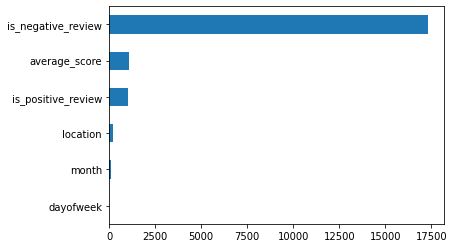

In [99]:
y=y.astype('int')

...
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [100]:
df = df.drop(['dayofweek', 'month'], axis=1)

Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn. В основе метода оценки значимости переменных лежит изученный вами в юнитах по статистике анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).

<AxesSubplot:>

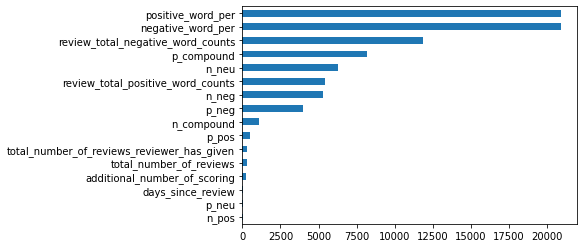

In [101]:
from sklearn.feature_selection import f_classif # anova

y = df.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = df.query('sample == 1').drop(['sample'], axis=1)[num_cols]

imp_num = pd.Series(f_classif(X, y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [102]:
df = df.drop(['n_pos', 'p_neu', 'days_since_review', 'additional_number_of_scoring', 'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given'], axis=1)

# 3. ML

In [103]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [104]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [105]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 51), (386803, 51), (386803, 50), (309442, 50), (77361, 50))

In [106]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [107]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [108]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


In [109]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.8712725806610306


<AxesSubplot:>

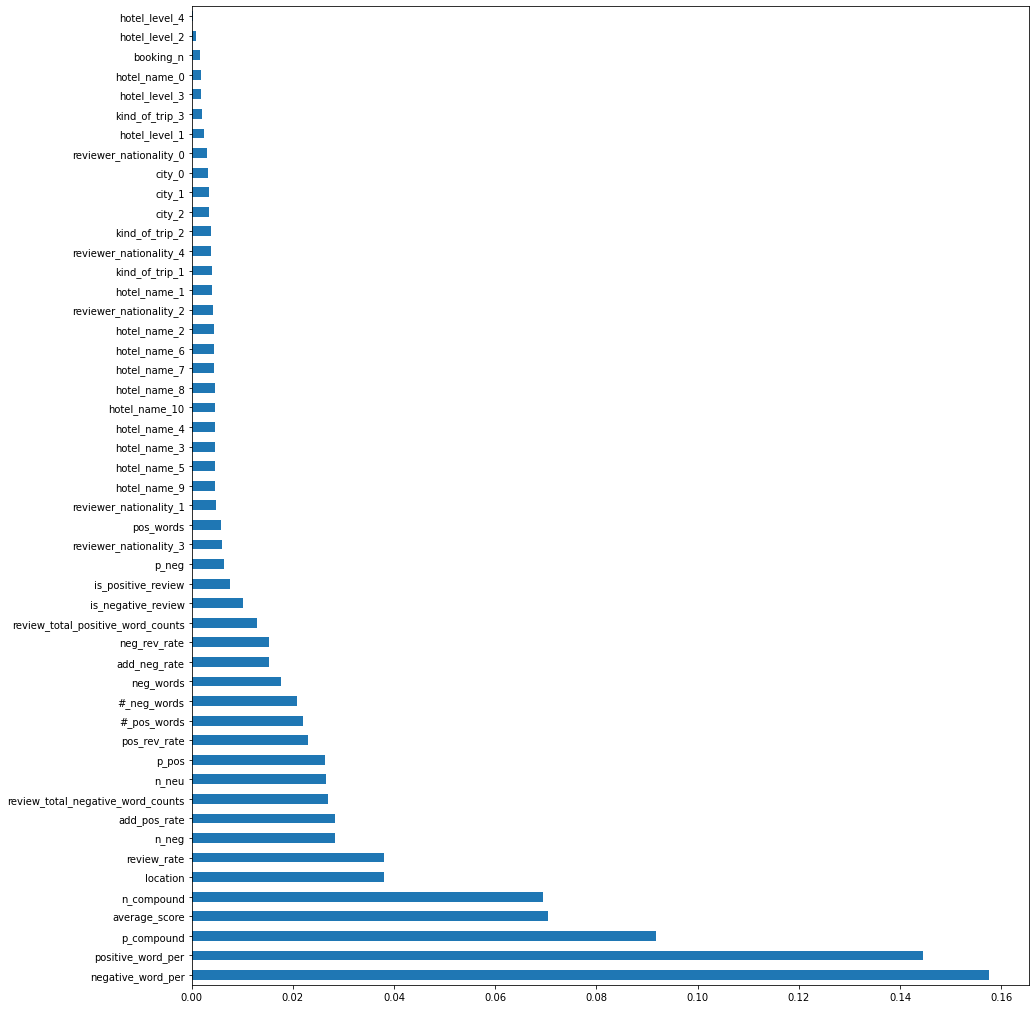

In [110]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (15,18)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(70).plot(kind='barh')

In [111]:
test_data.sample(10)

,reviewer_score,is_positive_review,is_negative_review,neg_words,pos_words,booking_n,n_neg,n_neu,n_compound,p_neg,...,#_neg_words,pos_rev_rate,neg_rev_rate,add_pos_rate,add_neg_rate,review_rate,average_score,location,review_total_negative_word_counts,review_total_positive_word_counts
102996,0.0,0,1,0,0,0,0.688,0.312,-0.2960,0.379,...,0.013333,0.000000,0.003036,0.000000,0.003036,0.001599,0.652174,0.088377,0.16,0.00
94711,0.0,1,1,0,1,0,0.194,0.806,-0.6124,0.000,...,0.250000,0.011938,0.011938,0.002551,0.011938,0.000321,0.717391,0.017271,1.00,1.00
112753,0.0,0,1,0,0,0,0.000,1.000,0.0000,0.379,...,1.000000,0.000000,0.050117,0.000000,0.050117,0.000338,0.804348,0.131621,1.00,0.00
98682,0.0,1,0,0,1,0,1.000,0.000,-0.7096,0.000,...,0.000000,0.035833,0.000000,0.012308,0.000000,0.003163,0.586957,0.146441,0.00,0.16
52639,0.0,1,0,0,1,0,1.000,0.000,-0.7096,0.000,...,0.000000,0.002046,0.000000,0.000159,0.000000,0.000127,0.913043,0.517230,0.00,0.20
119846,0.0,1,0,0,1,0,1.000,0.000,-0.7096,0.000,...,0.000000,0.006052,0.000000,0.000546,0.000000,0.000154,0.630435,0.265503,0.00,1.00
50466,0.0,1,0,0,1,0,0.041,0.959,-0.6640,0.000,...,0.500000,0.028571,0.071429,0.003509,0.071429,0.000996,0.760870,0.193986,1.00,0.40
55596,0.0,1,1,0,1,0,0.000,1.000,0.0000,0.000,...,0.083333,0.017515,0.087576,0.002353,0.087576,0.007446,0.891304,0.044078,1.00,0.20
46095,0.0,0,0,0,1,0,0.106,0.844,-0.3818,0.000,...,0.052632,0.040758,0.040758,0.006250,0.040758,0.005482,0.826087,0.115432,1.00,1.00
59681,0.0,1,1,0,1,0,0.524,0.476,-0.2960,0.000,...,0.066667,0.007972,0.001594,0.000770,0.001594,0.000152,0.760870,0.054582,0.20,1.00


In [112]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [113]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [114]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.3s finished


In [115]:
predict_submission

array([8.903, 7.831, 8.248, ..., 8.028, 9.661, 8.116])

In [116]:
list(sample_submission)

['reviewer_score', 'id']

In [117]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission_15_edit.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.903,488440
1,7.831,274649
2,8.248,374688
3,9.747,404352
4,9.429,451596
5,9.065,302161
6,7.843,317079
7,7.802,13963
8,8.702,159785
9,7.285,195089
